 # 0.0 IMPORTAÇÕES E FUNÇÕES DE AJUDA


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy                      import stats as ss
from sklearn.preprocessing      import RobustScaler, MinMaxScaler
from sklearn.model_selection    import train_test_split
from sklearn.ensemble           import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from boruta                     import BorutaPy
from sklearn.linear_model       import LinearRegression, LogisticRegression
from sklearn.metrics            import mean_absolute_error, mean_squared_error
import xgboost as xgb


import pickle

In [3]:
mms = MinMaxScaler()
rs = RobustScaler()

In [4]:
df_raw = pd.read_csv('data\cardio_train.csv', sep=';')
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corrigido = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)*(r-1)/(n-1)
    rcorr = r - (k-1)*(r-1)/(n-1)
    return np.sqrt((chi2/n) / (min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/ y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def model_acurracy(model_name, y_predict, y_test,):
    y_predict = np.array(y_predict)
    y_test = np.array(y_test)
    n = 0
    for i in range(len(y_test)):
        if y_predict[i] == y_test[i]:
            n = n + 1
    result = n/len(X_test)*100
    return print(f'O modelo {model_name} teve a acurácia de {result}%')


# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Tamanho do DataSet

In [7]:
print(f'Números de linhas: {df1.shape[0]}')
print(f'Números de colunas: {df1.shape[1]}')

Números de linhas: 70000
Números de colunas: 13


## 1.2 Nomes das Colunas

In [8]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 1.3 Tipos de Dados

In [9]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.5 Estatística Descritiva

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [12]:
# Tendencia Central - Media e Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Despesão - Desvio Padrão, Mínimo, Máximo, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
2,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
5,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
6,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.283482,2.905867,6.444250


# 2.0 FEATURE ENGENEERING

In [13]:
df2 = df1.copy()

In [14]:
# Criando a variável ano de nascimento.
df2['born_year'] = df2['age'].apply(lambda x: (dt.datetime.today() - dt.timedelta(days=x)).year)

# Criando coluna IMC
df2['imc'] = df2.apply(lambda x: x['weight'] / (x['height']/100)**2, axis=1)

# Trocando os valores da variável gender de 1-2 para 0-1
df2['gender'] = df2['gender'].apply(lambda x: 0 if x == 2 else 1)

# Criando coluna sobre hipertensão
df2['blood_pressure'] = df2[['ap_hi', 'ap_lo']].apply(lambda x: 'normal' if ((x['ap_lo'] <= 80) & (x['ap_hi'] <= 120 )) else
                                        'elevated' if (x['ap_lo'] <= 80) & (x['ap_hi'] > 120 | x['ap_hi'] <= 129) else
                                        'hypertension stage 1' if ((x['ap_lo'] > 80) | x['ap_lo'] <= 89 ) |  (x['ap_hi'] > 130 | x['ap_hi'] <= 139) else
                                        'hypertension stage 2' if (x['ap_lo'] >= 90) |  (x['ap_hi'] >= 140 )
                                        else 'NONE', axis=1)


# 3.0 FILTRAGEM DE DADOS

In [15]:
df3 = df2.copy()

In [16]:
# Removendo inconsistencias na pressão.
for i in range(len(df3)):
    if df3.loc[i, 'ap_hi'] < df3.loc[i, 'ap_lo']:
        df3 = df3.drop(i)

# Removendo inconsistencias na altura.
df3 = df3[df3['height'] > 130]
df3 = df3[df3['height'] < 210]

# Removendo inconsistencias na variável peso.
df3 = df3[df3['weight'] > 45]

# Removendo inconsistencias na pressão.
df3 = df3[df3['ap_lo'] > 50]
df3 = df3[df3['ap_lo'] < 170]
df3 = df3[df3['ap_hi'] > 80]
df3 = df3[df3['ap_hi'] < 210]


# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [17]:
df4 = df3.copy()

## 4.1 Análise Univariada

## 4.2 Análise Bivariada

1 - Pessoas com mais idade, em média tem mais propenção a ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

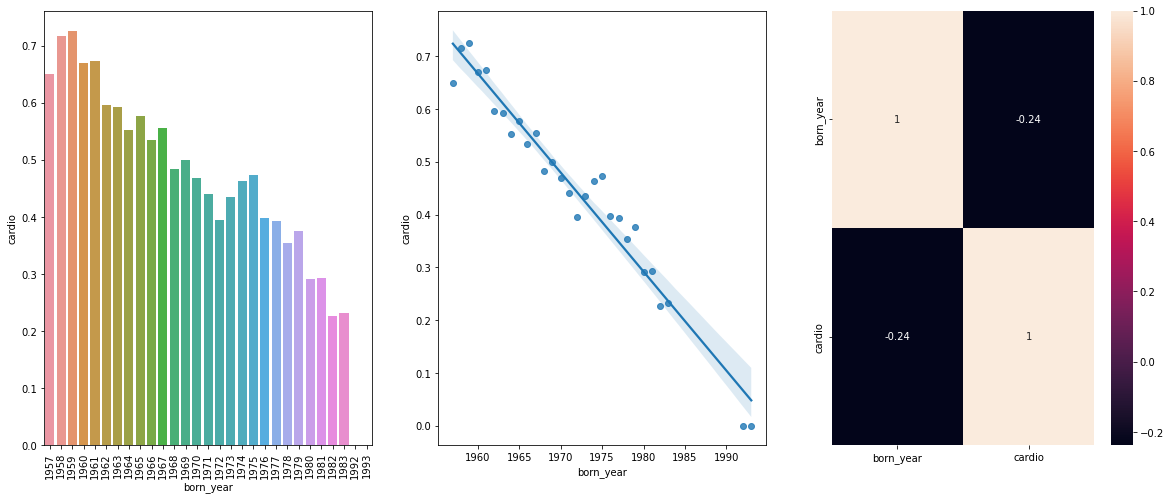

In [18]:
aux = df4[['born_year', 'cardio']].groupby('born_year').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='born_year', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='born_year', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['born_year', 'cardio']].corr(method='pearson'), annot=True)

2 - Homens e Mulheres tem em média chances diferentes de sofrer um ataque cardiaco. (Falso!)

<AxesSubplot:>

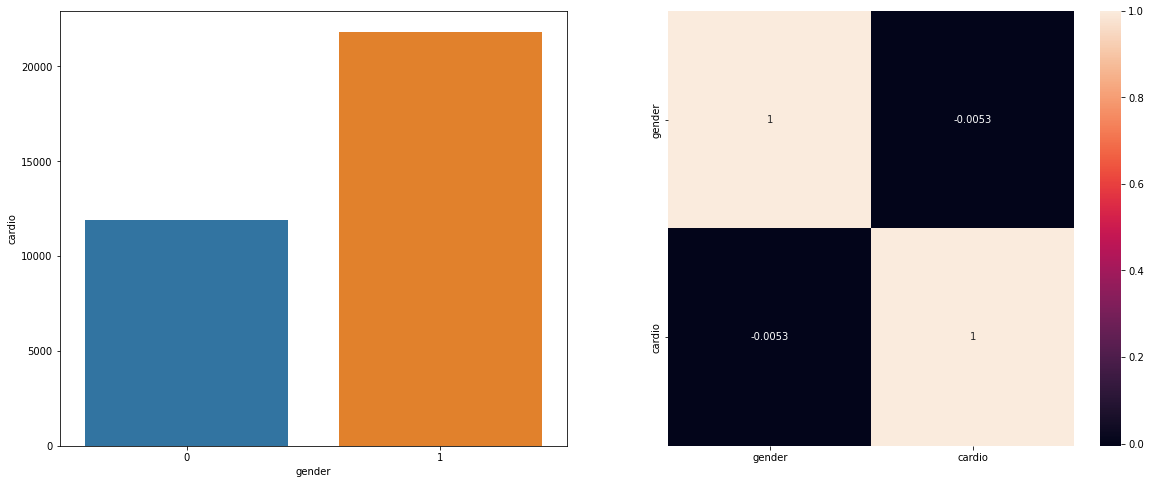

In [19]:
aux = df4[['gender', 'cardio', 'age']].groupby('gender').sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='gender', y='cardio', data=aux)
plt.subplot(1,2,2)
sns.heatmap(df4[['gender', 'cardio']].corr(method='pearson'), annot=True)

3 - Altura não aumenta as chances de ataque cardiaco. (Verdadeiro)

<AxesSubplot:>

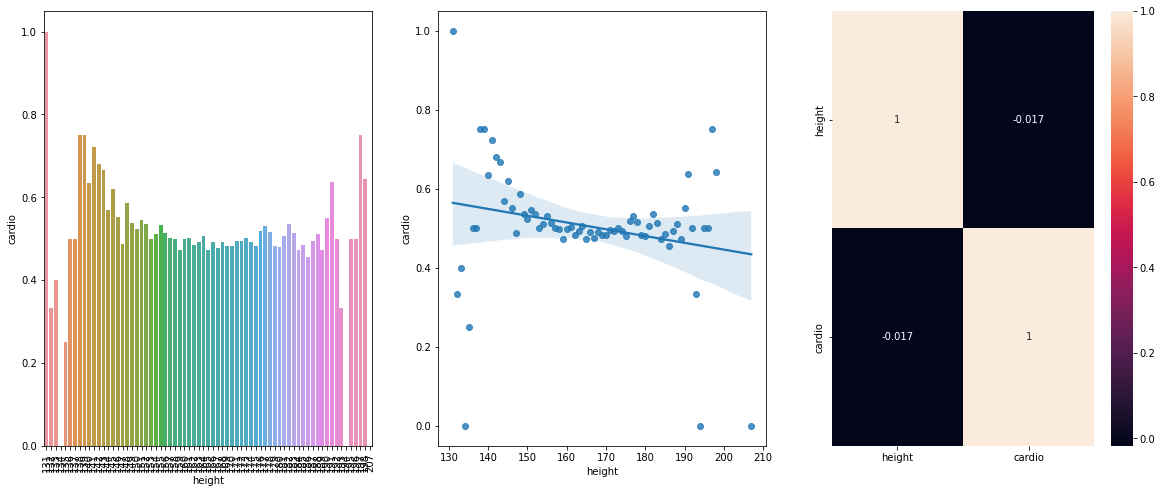

In [20]:
aux = df4[['height', 'cardio']].groupby('height').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='height', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='height', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['height', 'cardio']].corr(method='pearson'), annot=True)

4 - Quando maior o peso da pessoa, maior a chance de ela ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

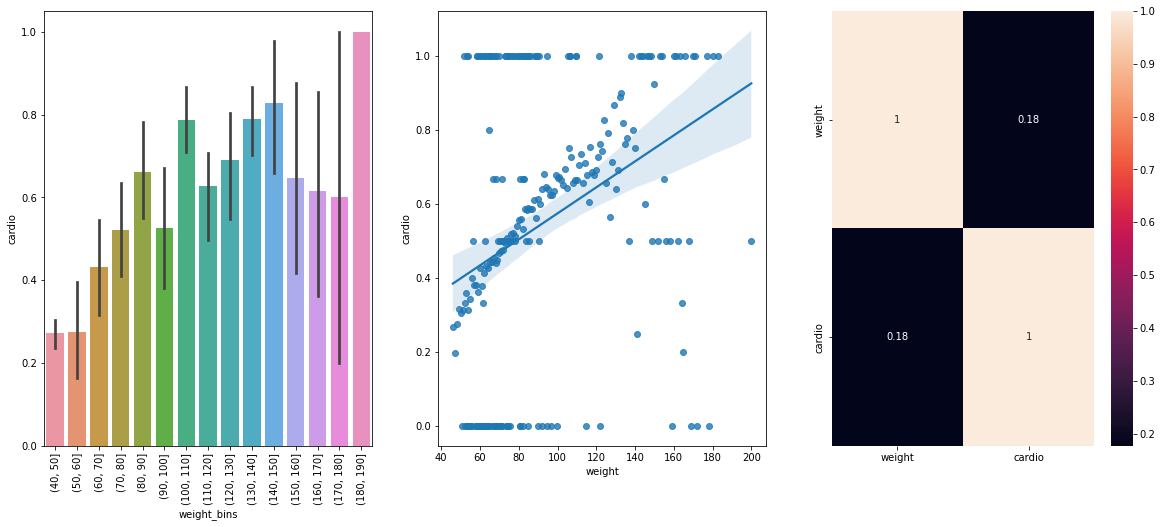

In [21]:
aux = df4[['weight', 'cardio']].groupby('weight').mean().reset_index()


bins = list(np.arange(40,200, 10))

aux['weight_bins'] = pd.cut(aux['weight'], bins=bins)
aux1 = aux[['weight_bins', 'cardio']].groupby('weight_bins').sum().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='weight_bins', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='weight', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['weight', 'cardio']].corr(method='pearson'), annot=True)

5 - Quanto pior o quadro de hypertensão, maior é a chance de um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

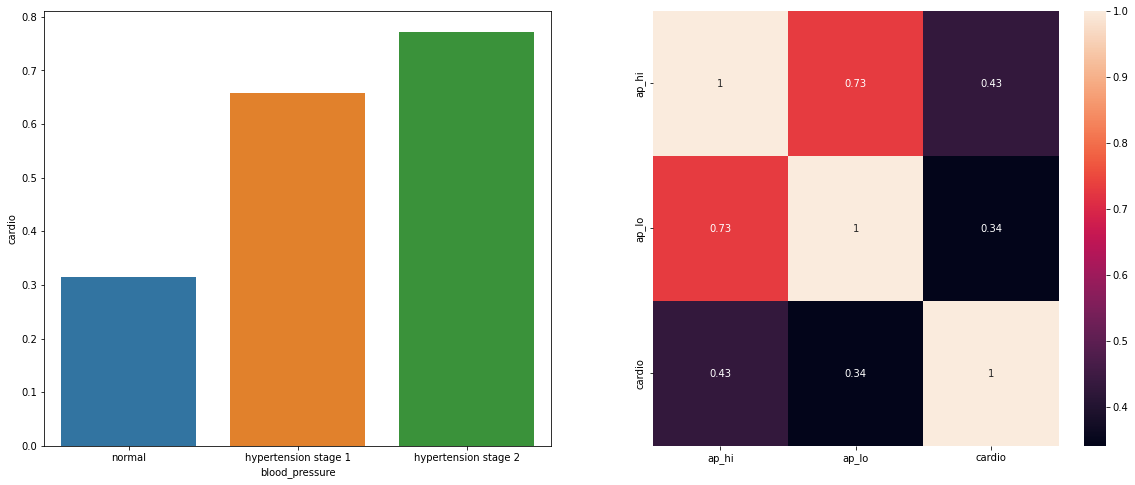

In [22]:
aux = df4[['blood_pressure', 'cardio']].groupby('blood_pressure').mean().reset_index().sort_values('cardio')

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='blood_pressure', y='cardio', data=aux)
plt.subplot(1,2,2)
sns.heatmap(df4[['ap_hi', 'ap_lo', 'cardio']].corr(method='pearson'), annot=True)

6 - Quanto pior o quadro de colesterol, maior é a chance de um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

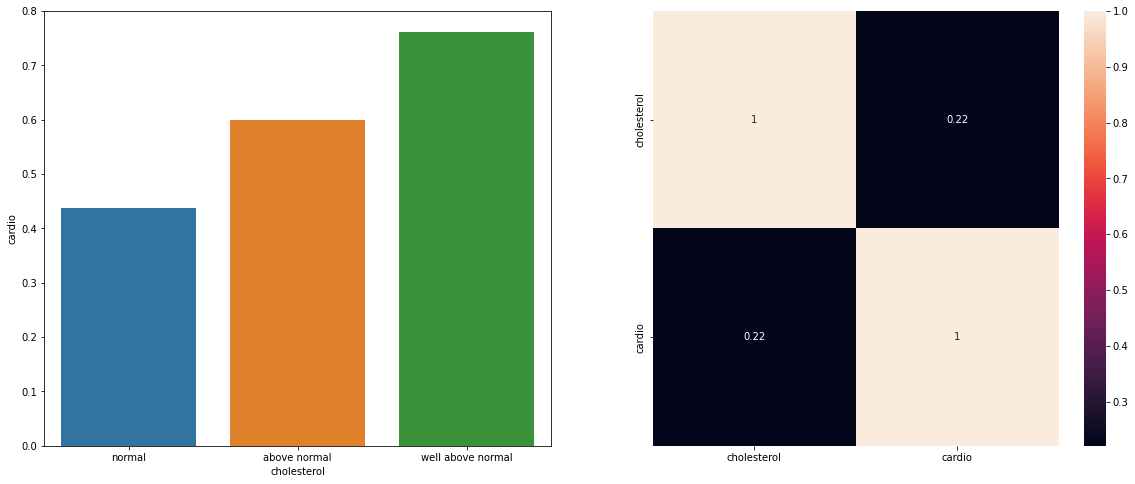

In [23]:
aux = df4[['cholesterol', 'cardio']].groupby('cholesterol').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.barplot(x='cholesterol', y='cardio', data=aux).set_xticklabels(['normal', 'above normal', 'well above normal'])

plt.subplot(1,2,2)
sns.heatmap(df4[['cholesterol', 'cardio']].corr(method='pearson'), annot=True)

7 - Quanto pior o quadro de diabetes, maior é a chance de ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

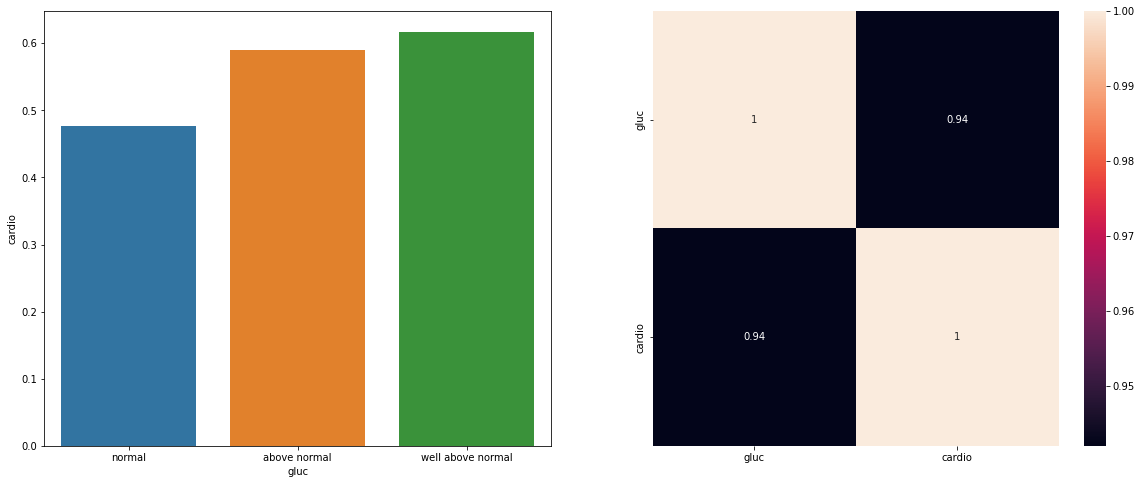

In [24]:
aux = df4[['gluc', 'cardio']].groupby('gluc').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='gluc', y='cardio', data=aux).set_xticklabels(['normal', 'above normal', 'well above normal'])

plt.subplot(1,2,2)
sns.heatmap(aux.corr(method='pearson'), annot=True)

8 - Pessoas que fumam, tem em média maior chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

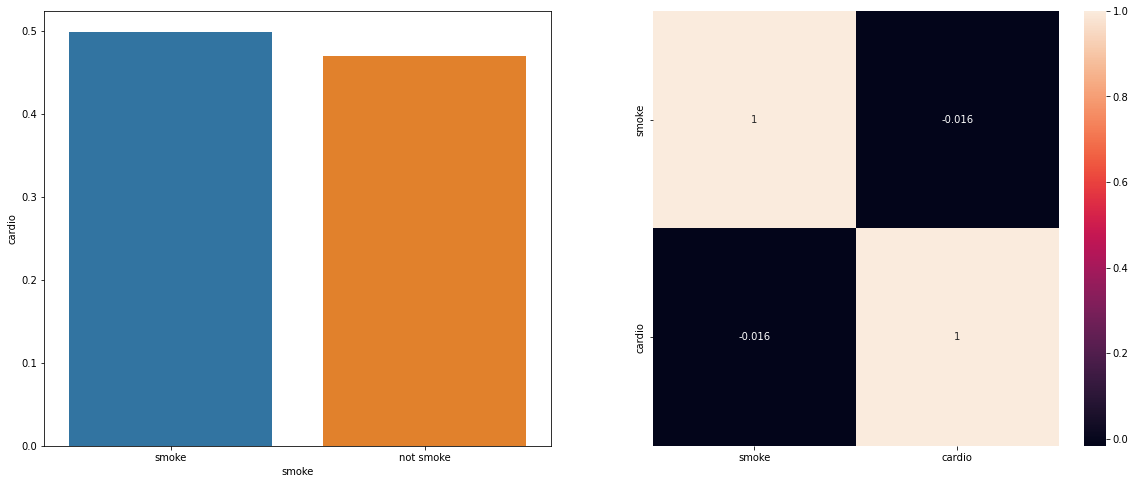

In [25]:
aux = df4[['smoke', 'cardio']].groupby('smoke').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='smoke', y='cardio', data=aux).set_xticklabels(['smoke', 'not smoke'])

plt.subplot(1,2,2)
sns.heatmap(df4[['smoke', 'cardio']].corr(method='pearson'), annot=True)

9 - Pessoas que alcool, tem em média maior chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

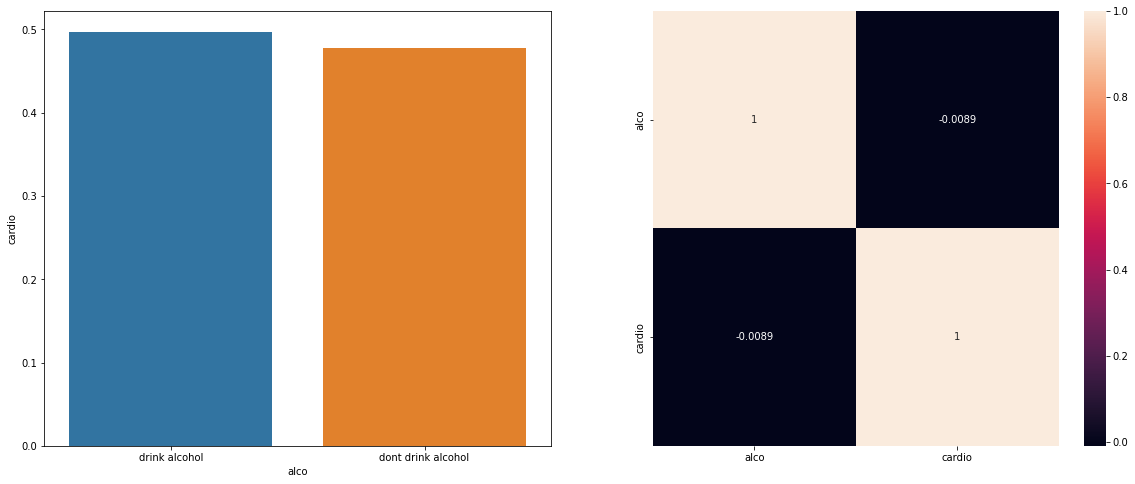

In [26]:
aux = df4[['alco', 'cardio']].groupby('alco').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='alco', y='cardio', data=aux).set_xticklabels(['drink alcohol', 'dont drink alcohol'])

plt.subplot(1,2,2)
sns.heatmap(df4[['alco', 'cardio']].corr(method='pearson'), annot=True)

10 - Pessoas que alcool, tem em média menor chance de ter um ataque cardiaco. (Falso!)

<AxesSubplot:>

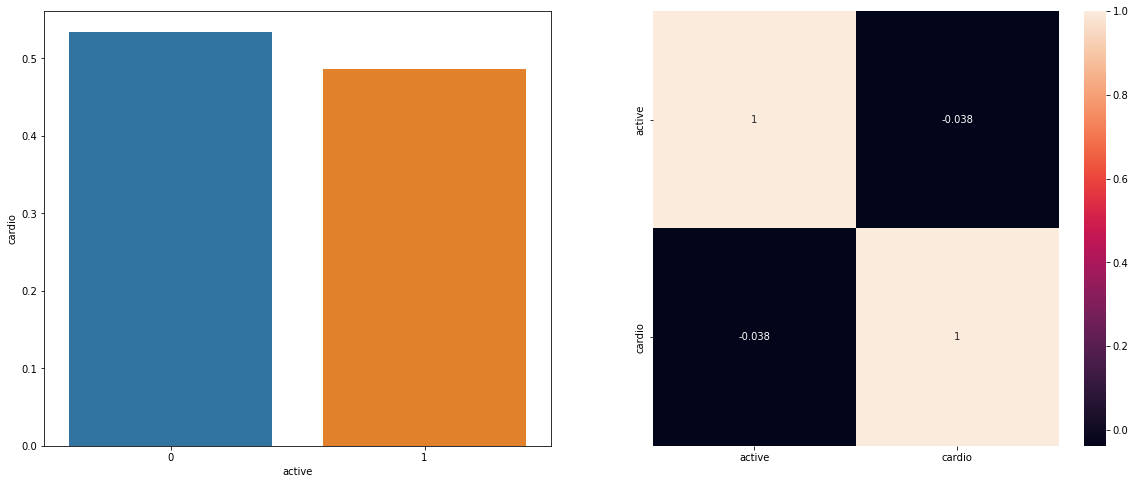

In [27]:
aux = df4[['active', 'cardio']].groupby('active').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(x='active', y='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(df4[['active', 'cardio']].corr(method='pearson'), annot=True)

11 - Pessoas com imc maior, em média tem mais propenção a ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

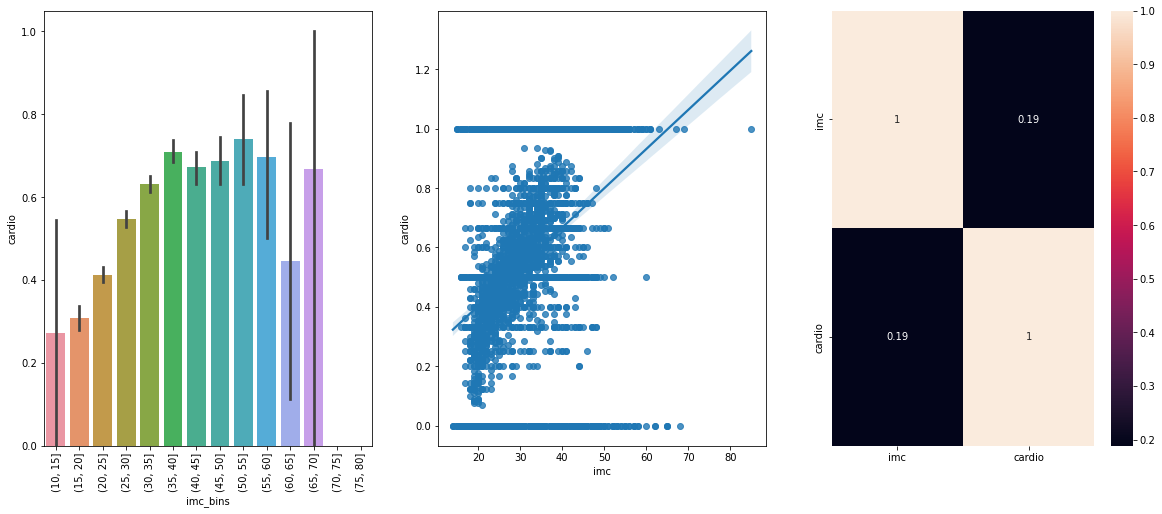

In [28]:
aux = df4[['imc', 'cardio']].groupby('imc').mean().reset_index()
aux['imc'] = np.int64(aux['imc'])

bins = list(np.arange(10,85, 5))

aux['imc_bins'] = pd.cut(aux['imc'], bins=bins)
aux1 = aux[['imc_bins', 'cardio']].groupby('imc_bins').sum().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='imc_bins', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='imc', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['imc', 'cardio']].corr(method='pearson'), annot=True)

## 4.3 Análise Multivariada

### 4.5.1 Variáveis Numéricas

<AxesSubplot:>

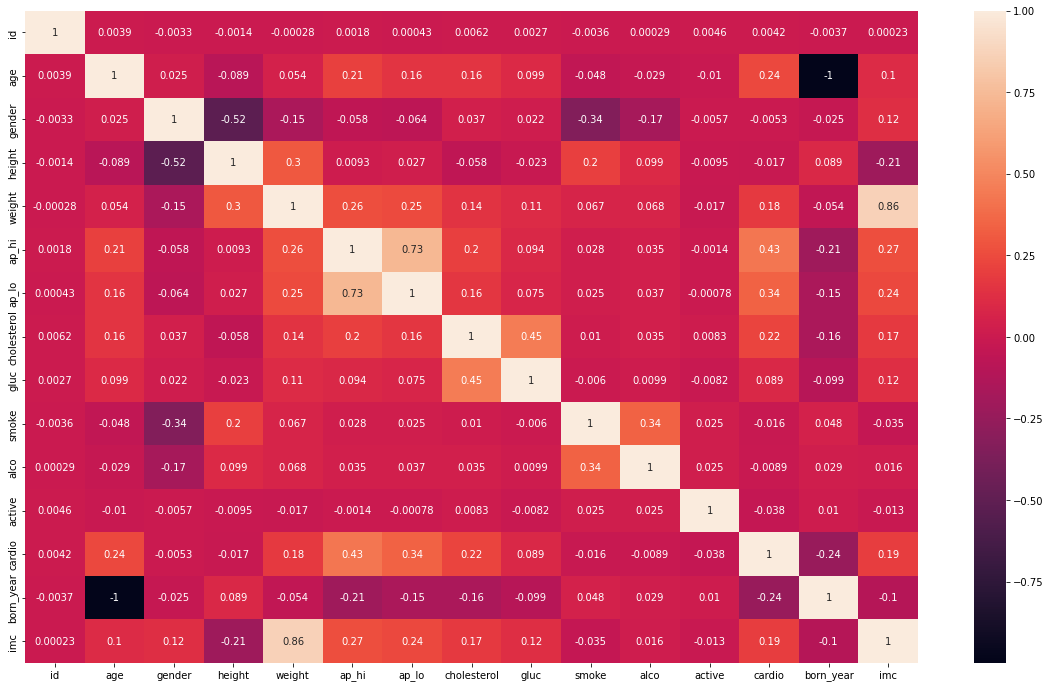

In [29]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20,12))
sns.heatmap(num_attributes.corr(method='pearson'), annot=True)

# 5.0 PREPARAÇÃO DOS DADOS

In [30]:
df5 = df4.copy()

## 5.1 Rescaling

In [31]:
df5['age'] = mms.fit_transform(df5[['age']].values)
pickle.dump(mms, open('parameters/age.pkl', 'wb'))

df5['born_year'] = mms.fit_transform(df5[['born_year']].values)
pickle.dump(mms, open('parameters/ap_lo.pkl', 'wb'))

df5['age'] = mms.fit_transform(df5[['age']].values)
pickle.dump(mms, open('parameters/age.pkl', 'wb'))

df5['height'] = rs.fit_transform(df5[['height']].values)
pickle.dump(rs, open('parameters/height.pkl', 'wb'))

df5['weight'] = rs.fit_transform(df5[['weight']].values)
pickle.dump(rs, open('parameters/weight.pkl', 'wb'))

df5['ap_hi'] = rs.fit_transform(df5[['ap_hi']].values)
pickle.dump(rs, open('parameters/ap_hi.pkl', 'wb'))

df5['ap_lo'] = rs.fit_transform(df5[['ap_lo']].values)
pickle.dump(rs, open('parameters/ap_lo.pkl', 'wb'))

df5['imc'] = rs.fit_transform(df5[['imc']].values)
pickle.dump(rs, open('parameters/imc.pkl', 'wb'))


## 5.2 Encoding

In [32]:
bs_dict = {'normal': 1, 'hypertension stage 1': 2, 'hypertension stage 2': 3}
df5['blood_pressure'] = df5['blood_pressure'].map(bs_dict)

# 6.0 SELEÇÃO DE FEATURES

In [33]:
df6 = df5.copy()

## 6.1 Separando DataFrame em treino e teste

In [34]:
y = df6['cardio']
X = df6.drop(['id', 'cardio'], axis=1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [36]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

rf = RandomForestRegressor(n_jobs=-1)

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	12


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	12


In [37]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
cols_not_selected_boruta = list(np.setdiff1d( X_train.columns, cols_selected_boruta))

In [38]:
cols_selected_boruta

['age', 'ap_hi']

# 7.0 MACHINE LEARNING

In [39]:
lr = LogisticRegression().fit(X_train, y_train)


yhat_lr = lr.predict(X_test)

model_log_reg = model_acurracy('Logistic_Regression', yhat_lr, y_test)
model_log_reg 

O modelo Logistic_Regression teve a acurácia de 72.25436360070601%


In [40]:
xgb_class = xgb.XGBClassifier().fit(X_train, y_train)

yhat_lr = xgb_class.predict(X_test)

model_xgb_class = model_acurracy('XGBClassifier', yhat_lr, y_test)
model_xgb_class

O modelo XGBClassifier teve a acurácia de 72.53383016277701%


In [41]:
rf_class = RandomForestClassifier().fit(X_train, y_train)

yhat_lr = rf_class.predict(X_test)

model_rf_class = model_acurracy('RandomForestClassifier', yhat_lr, y_test)
model_rf_class

O modelo XGBClassifier teve a acurácia de 71.11198274171406%


In [1]:
from catboost import CatBoostClassifier
cb_class = CatBoostClassifier(iterations=5,
                              learning_rate=0.0001,
                              task_type="GPU",
                              depth=16).fit(X_train, y_train)

yhat_lr = cb_class.predict(X_test)

model_cb_class = model_acurracy('CatBoostClassifier', yhat_lr, y_test)
model_cb_class

NameError: name 'X_train' is not defined

In [3]:
X_train_n

NameError: name 'X_train_n' is not defined